# Generating predictions

This notebook is based in the previous one: 'Price prediction with LSTM neural networks'
Este Notebook se apoya en el desarrollo de **Predicción de Series Temporales (Forex)** para cargar un archivo CSV y realizar todas las predicciones conforme a un modelo dado, utilizando unos pesos y un scaler previamente guardados en disco.

La predicción generará un nuevo archivo CSV con las predicciones dadas.

In [3]:
import sys
sys.path.append('../../..')

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls


####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

In [4]:
import common.MyUtils as utils
print('Ready!')

Ready!


In [5]:
# Cargo el histórico en el dataframe 'df' y visualizo los primeros registros
df = utils.load_hist('../../csv_data/EURUSD_H4.csv', freq='4H', sep=';', remove_weekends=True)
df.head()


Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2000-01-03 04:00:00,1.0173,1.0181,1.0154,1.0157,1.01650,1.016400,1.016625,-0.0018,240,0,609.0,0.0,50.0
2000-01-03 08:00:00,1.0154,1.0167,1.0093,1.0115,1.01345,1.012500,1.013225,-0.0042,480,0,1731.0,0.0,50.0
2000-01-03 12:00:00,1.0118,1.0118,1.0054,1.0073,1.00955,1.008167,1.009075,-0.0042,720,0,1562.0,0.0,50.0
2000-01-03 16:00:00,1.0077,1.0240,1.0070,1.0218,1.01475,1.017600,1.015125,0.0145,960,0,1484.0,0.0,50.0
2000-01-03 20:00:00,1.0218,1.0278,1.0213,1.0246,1.02320,1.024567,1.023875,0.0028,1200,0,586.0,0.0,50.0


In [6]:
df.tail()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2019-03-29 20:00:00,1.12251,1.12272,1.12131,1.12176,1.122135,1.121930,1.122075,-0.00075,1200,4,15027.0,0.0,0.0
2019-04-01 00:00:00,1.12255,1.12314,1.12202,1.12281,1.122680,1.122657,1.122630,0.00105,0,0,3766.0,0.0,0.0
2019-04-01 04:00:00,1.12281,1.12352,1.12243,1.12342,1.123115,1.123123,1.123045,0.00061,240,0,6006.0,0.0,0.0
2019-04-01 08:00:00,1.12342,1.12501,1.12275,1.12466,1.124040,1.124140,1.123960,0.00124,480,0,25718.0,0.0,0.0
2019-04-01 12:00:00,1.12466,1.12487,1.12294,1.12303,1.123845,1.123613,1.123875,-0.00163,720,0,10688.0,0.0,0.0


In [7]:
# Incluyo los indicadores técnicos más representativos y visualizo todas las columnas del nuevo dataframe 'df'
df = utils.add_indicators(df, applied=['HIGH','LOW'], base_cols=['OPEN','HIGH','LOW','CLOSE','OC2','HLC3','OHLC4'])
print(df.columns)
df.head(1)

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'OC2', 'HLC3', 'OHLC4',
       'IND_BB_UPPER_HIGH', 'IND_BB_MIDDLE_HIGH', 'IND_BB_LOWER_HIGH',
       'IND_BB_WIDTH_HIGH', 'IND_BB_PERCENT_HIGH', 'IND_BB_WIDTH_SMA4_HIGH',
       'IND_BB_WIDTH_SMA12_HIGH', 'IND_SMA4_HIGH', 'IND_SMA16_HIGH',
       'IND_SMA40_HIGH', 'IND_MACD_HIGH', 'IND_MACD_SIG_HIGH',
       'IND_MACD_HIST_HIGH', 'IND_RSI_HIGH', 'IND_APO_HIGH', 'IND_MOM_HIGH',
       'IND_ROCP_HIGH', 'IND_ROCR_HIGH', 'IND_BB_UPPER_LOW',
       'IND_BB_MIDDLE_LOW', 'IND_BB_LOWER_LOW', 'IND_BB_WIDTH_LOW',
       'IND_BB_PERCENT_LOW', 'IND_BB_WIDTH_SMA4_LOW', 'IND_BB_WIDTH_SMA12_LOW',
       'IND_SMA4_LOW', 'IND_SMA16_LOW', 'IND_SMA40_LOW', 'IND_MACD_LOW',
       'IND_MACD_SIG_LOW', 'IND_MACD_HIST_LOW', 'IND_RSI_LOW', 'IND_APO_LOW',
       'IND_MOM_LOW', 'IND_ROCP_LOW', 'IND_ROCR_LOW', 'IND_WILLR', 'IND_ATR',
       'IND_ATR_SMA4', 'IND_ATR_SMA12', 'IND_ADX', 'IND_ADXR', 'IND_CCI',
       'IND_SLOWK', 'IND_SLOWD'],
      dtype='object')


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ROCR_LOW,IND_WILLR,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD
2000-01-11 20:00:00,1.0315,1.0341,1.0309,1.0336,1.03255,1.032867,1.032525,1.036389,1.030785,1.025181,...,1.003602,-3.846154,0.004428,0.004448,0.004649,16.35667,22.545787,164.2718,75.337646,74.469078


In [8]:
# función para generar las salidas a predecir
def define_outputs(df):  
  df['OUT_HIGH'] = df.HIGH - df.CLOSE.shift(1)
  df['OUT_LOW'] = df.LOW - df.CLOSE.shift(1)
  return df

# Añado las salidas a predecir al dataframe 'df'
df = define_outputs(df)
df.dropna(inplace=True)
df.tail()

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,IND_BB_UPPER_HIGH,IND_BB_MIDDLE_HIGH,IND_BB_LOWER_HIGH,...,IND_ATR,IND_ATR_SMA4,IND_ATR_SMA12,IND_ADX,IND_ADXR,IND_CCI,IND_SLOWK,IND_SLOWD,OUT_HIGH,OUT_LOW
2019-03-29 20:00:00,1.12251,1.12272,1.12131,1.12176,1.122135,1.121930,1.122075,1.130044,1.125875,1.121706,...,0.002213,0.002238,0.002294,40.080955,35.133255,-104.200992,40.851449,50.107577,0.00021,-0.00120
2019-04-01 00:00:00,1.12255,1.12314,1.12202,1.12281,1.122680,1.122657,1.122630,1.129399,1.125531,1.121663,...,0.002154,0.002232,0.002280,40.463994,35.616560,-55.957142,37.500000,44.640819,0.00138,0.00026
2019-04-01 04:00:00,1.12281,1.12352,1.12243,1.12342,1.123115,1.123123,1.123045,1.128740,1.125233,1.121726,...,0.002078,0.002180,0.002265,40.392259,35.851635,-14.291348,45.742754,41.364734,0.00071,-0.00038
2019-04-01 08:00:00,1.12342,1.12501,1.12275,1.12466,1.124040,1.124140,1.123960,1.128414,1.125098,1.121781,...,0.002091,0.002134,0.002248,38.851222,35.215077,90.279888,68.857716,50.700157,0.00159,-0.00067
2019-04-01 12:00:00,1.12466,1.12487,1.12294,1.12303,1.123845,1.123613,1.123875,1.128236,1.125005,1.121773,...,0.002079,0.002100,0.002221,37.420259,34.796668,64.574329,67.777125,60.792532,0.00021,-0.00172


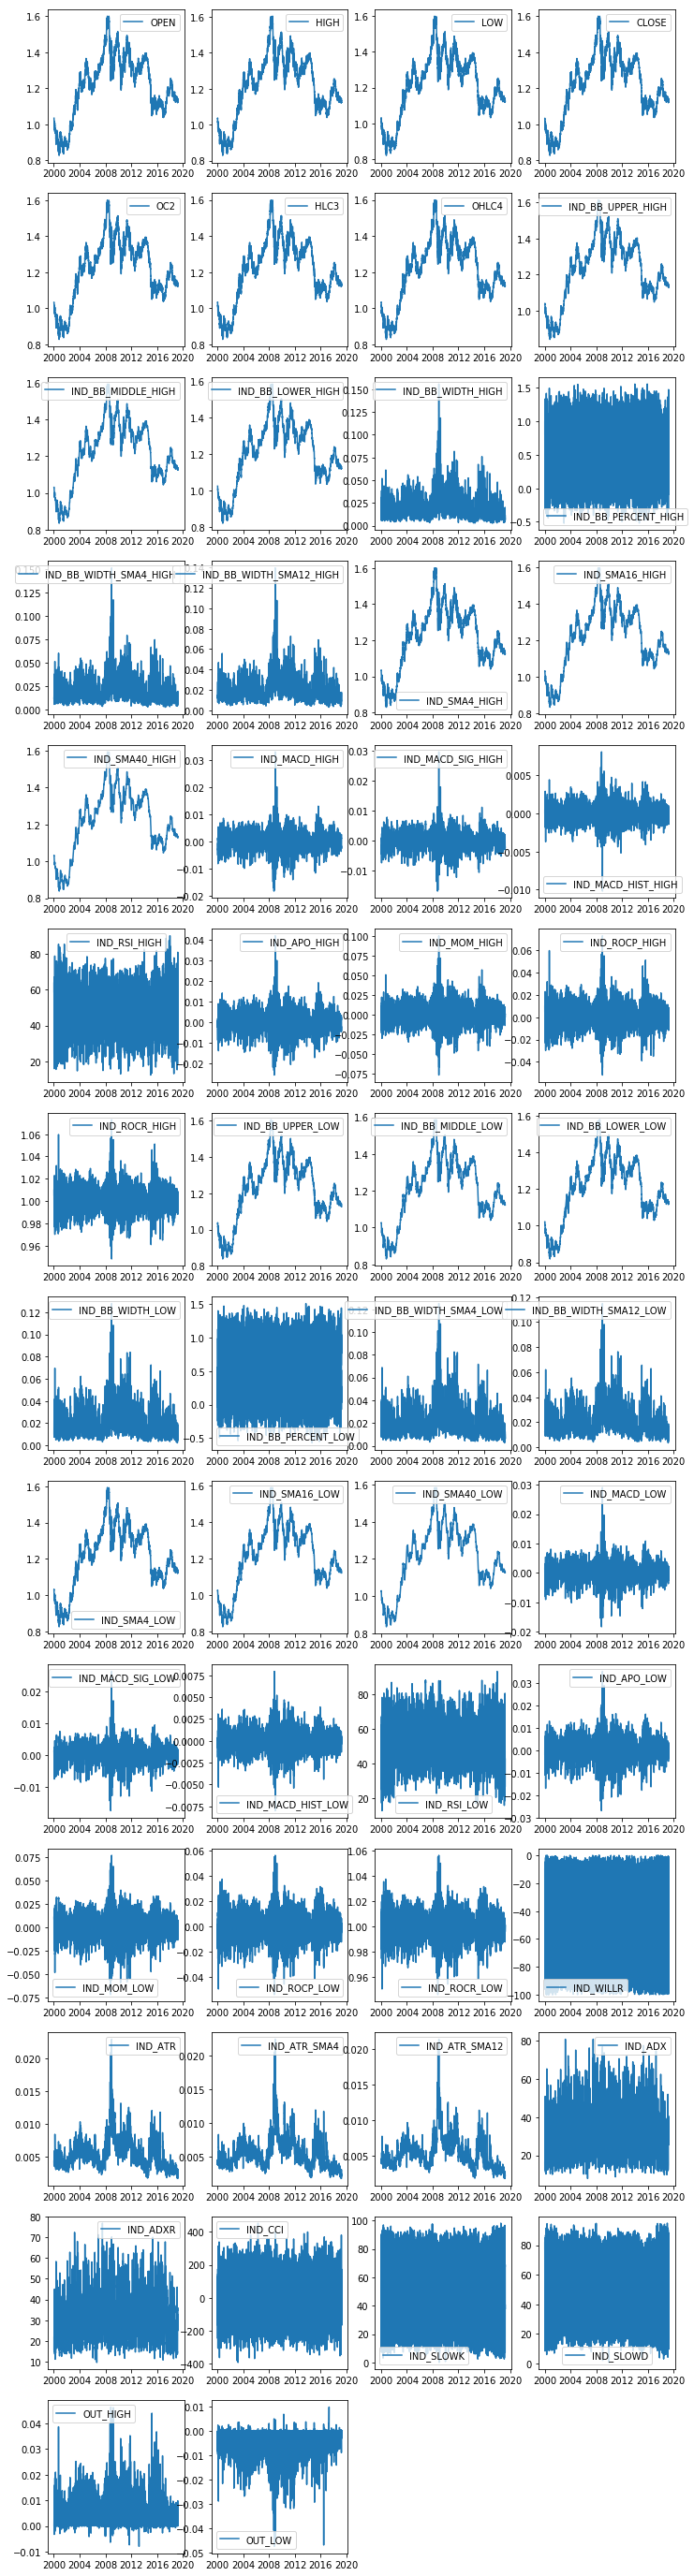

In [10]:
# Visualizo gráficamente todos los 'features' que forman el dataframe 'df', incluyendo las salidas a predecir
rows = (df.shape[1] / 4) + 1
plt.figure(figsize = (12,50))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])
  

In [12]:
# Defino el formato del dataframe 'df_nn' que voy a obtener como proceso de adaptación. Es necesario definir las siguientes
# variables que se utilizarán a lo largo del desarrollo

# Número de salidas a predecir
num_outputs = 2

# Número de 'features' de entrada
num_inputs = len(df.columns) - num_outputs

# Número de timesteps previos
n_in = 4

# Número de timesteps a futuro
n_out = 1

# Flag para eliminar NaNs del dataframe resultante tras aplicar la adaptación
dropnan = False

# Procesa la adaptación al dataframe 'df' y genera un nuevo dataframe 'df_nn'
df_nn = utils.series_to_supervised(df, num_inputs, num_outputs, n_in, n_out, dropnan)
print(df_nn.shape)
df_nn.tail()

(30082, 210)


,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2019-03-29 20:00:00,1.12302,1.12390,1.12222,1.12302,1.123020,1.123047,1.123040,1.132781,1.127120,1.121459,...,0.002213,0.002238,0.002294,40.080955,35.133255,-104.200992,40.851449,50.107577,0.00138,0.00026
2019-04-01 00:00:00,1.12302,1.12466,1.12098,1.12318,1.123100,1.122940,1.122960,1.131990,1.126743,1.121496,...,0.002154,0.002232,0.002280,40.463994,35.616560,-55.957142,37.500000,44.640819,0.00071,-0.00038
2019-04-01 04:00:00,1.12319,1.12418,1.12205,1.12251,1.122850,1.122913,1.122982,1.131209,1.126369,1.121528,...,0.002078,0.002180,0.002265,40.392259,35.851635,-14.291348,45.742754,41.364734,0.00159,-0.00067
2019-04-01 08:00:00,1.12251,1.12272,1.12131,1.12176,1.122135,1.121930,1.122075,1.130044,1.125875,1.121706,...,0.002091,0.002134,0.002248,38.851222,35.215077,90.279888,68.857716,50.700157,0.00021,-0.00172
2019-04-01 12:00:00,1.12255,1.12314,1.12202,1.12281,1.122680,1.122657,1.122630,1.129399,1.125531,1.121663,...,0.002079,0.002100,0.002221,37.420259,34.796668,64.574329,67.777125,60.792532,NaN,NaN


In [25]:
# Elimino NaN y borro último resultado
df_nn['OUT_HIGH(t+1)'][-1] = 0
df_nn['OUT_LOW(t+1)'][-1] = 0
df_nn.dropna(inplace=True)
df_nn.tail()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2019-03-29 20:00:00,1.12302,1.12390,1.12222,1.12302,1.123020,1.123047,1.123040,1.132781,1.127120,1.121459,...,0.002213,0.002238,0.002294,40.080955,35.133255,-104.200992,40.851449,50.107577,0.00138,0.00026
2019-04-01 00:00:00,1.12302,1.12466,1.12098,1.12318,1.123100,1.122940,1.122960,1.131990,1.126743,1.121496,...,0.002154,0.002232,0.002280,40.463994,35.616560,-55.957142,37.500000,44.640819,0.00071,-0.00038
2019-04-01 04:00:00,1.12319,1.12418,1.12205,1.12251,1.122850,1.122913,1.122982,1.131209,1.126369,1.121528,...,0.002078,0.002180,0.002265,40.392259,35.851635,-14.291348,45.742754,41.364734,0.00159,-0.00067
2019-04-01 08:00:00,1.12251,1.12272,1.12131,1.12176,1.122135,1.121930,1.122075,1.130044,1.125875,1.121706,...,0.002091,0.002134,0.002248,38.851222,35.215077,90.279888,68.857716,50.700157,0.00021,-0.00172
2019-04-01 12:00:00,1.12255,1.12314,1.12202,1.12281,1.122680,1.122657,1.122630,1.129399,1.125531,1.121663,...,0.002079,0.002100,0.002221,37.420259,34.796668,64.574329,67.777125,60.792532,0.00000,0.00000


In [27]:
# chequeo que la generación de las salidas a predecir es correcta mediante un dataframe temporal '_df' con las columnas más
# representativas. Verificaré que la columna 'next_high' coincide con 'HIGH(t)' desplazada 1 sesión en el futuro
_df = df_nn[['HIGH(t-1)','HIGH(t)','LOW(t-1)','LOW(t)','CLOSE(t-1)', 'CLOSE(t)','OUT_HIGH(t+1)']].tail(10).copy()
_df['next_high'] = _df['CLOSE(t)']+ _df['OUT_HIGH(t+1)']
_df

,HIGH(t-1),HIGH(t),LOW(t-1),LOW(t),CLOSE(t-1),CLOSE(t),OUT_HIGH(t+1),next_high
2019-03-29 00:00:00,1.12378,1.12351,1.12200,1.12185,1.12200,1.12321,0.00011,1.12332
2019-03-29 04:00:00,1.12351,1.12332,1.12185,1.12234,1.12321,1.12302,0.00088,1.12390
2019-03-29 08:00:00,1.12332,1.12390,1.12234,1.12222,1.12302,1.12302,0.00164,1.12466
2019-03-29 12:00:00,1.12390,1.12466,1.12222,1.12098,1.12302,1.12318,0.00100,1.12418
2019-03-29 16:00:00,1.12466,1.12418,1.12098,1.12205,1.12318,1.12251,0.00021,1.12272
2019-03-29 20:00:00,1.12418,1.12272,1.12205,1.12131,1.12251,1.12176,0.00138,1.12314
2019-04-01 00:00:00,1.12272,1.12314,1.12131,1.12202,1.12176,1.12281,0.00071,1.12352
2019-04-01 04:00:00,1.12314,1.12352,1.12202,1.12243,1.12281,1.12342,0.00159,1.12501
2019-04-01 08:00:00,1.12352,1.12501,1.12243,1.12275,1.12342,1.12466,0.00021,1.12487
2019-04-01 12:00:00,1.12501,1.12487,1.12275,1.12294,1.12466,1.12303,0.00000,1.12303


In [28]:
#### Normalización de los datos sobre el datafram 'df_nn'. Genero un nuevo dataframe 'dfnorm'
dfnorm, scaler = utils.normalize_data(df_nn, feat_range = (-1,1), csv_to_save=None, scaler_to_save='../../scaler_data/scaler.data')
# Verifico los datos del nuevo dataframe generado
dfnorm.describe()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
count,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,...,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000,30079.000000
mean,0.000798,0.000428,0.002330,0.000660,0.000276,0.000884,0.000798,-0.001479,0.004438,0.006069,...,-0.648288,-0.642193,-0.631455,-0.340184,-0.335236,-0.064518,0.019453,0.047050,-0.606698,0.565206
std,0.436660,0.435875,0.434614,0.436336,0.436678,0.437007,0.436940,0.442164,0.444003,0.439207,...,0.206891,0.211561,0.222432,0.344678,0.334888,0.261646,0.408642,0.384379,0.117524,0.112075
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.256091,-0.256511,-0.252486,-0.255938,-0.256188,-0.255785,-0.255632,-0.263539,-0.255776,-0.251937,...,-0.794168,-0.791762,-0.789285,-0.605397,-0.592689,-0.273098,-0.296752,-0.247620,-0.677087,0.537814
50%,0.050874,0.049768,0.053003,0.050712,0.050363,0.050680,0.050719,0.047453,0.055152,0.058395,...,-0.681171,-0.674761,-0.664503,-0.406704,-0.392158,-0.060770,0.019950,0.048567,-0.643987,0.600281
75%,0.315987,0.313950,0.316311,0.315666,0.315387,0.316110,0.315828,0.313781,0.322715,0.324198,...,-0.557104,-0.548447,-0.532975,-0.124864,-0.128009,0.141191,0.335870,0.341339,-0.581464,0.633971
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
# Creo el mismo modelo neuronal utilizado durante la validación  cruzada
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'../../hd5_data/weights_3.2.64.128.hd5')

In [30]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
predictions = model.predict(X.reshape(X.shape[0], n_in, num_inputs), batch_size=1)
predictions.shape

(30079, 2)

In [31]:
# hago una copia del dataframe de entrada normalizado y pego las predicciones
df_predict = dfnorm.copy()
df_predict['OUT_HIGH(t+1)'] = predictions[:,0]
df_predict['OUT_LOW(t+1)']  = predictions[:,1]
df_predict.tail(2)

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2019-04-01 08:00:00,-0.234667,-0.240536,-0.228697,-0.236585,-0.236186,-0.236306,-0.235976,-0.250840,-0.232756,-0.215060,...,-0.961520,-0.959644,-0.956045,-0.150590,-0.237485,0.142417,0.403417,0.061527,-0.558979,0.638207
2019-04-01 12:00:00,-0.234563,-0.239454,-0.226863,-0.233868,-0.234775,-0.234423,-0.234538,-0.252514,-0.233660,-0.215174,...,-0.962599,-0.962876,-0.958781,-0.189749,-0.249894,0.081627,0.381393,0.276053,-0.552745,0.636313


In [32]:
# Denormalizo los datos
df_predict = utils.denormalize_data(df_predict, scaler)
df_predict.tail()

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR(t),IND_ATR_SMA4(t),IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1)
2019-03-29 20:00:00,1.12302,1.12390,1.12222,1.12302,1.123020,1.123047,1.123040,1.132781,1.127120,1.121459,...,0.002213,0.002238,0.002294,40.080956,35.133255,-104.200996,40.851448,50.107574,0.004038,-0.000567
2019-04-01 00:00:00,1.12302,1.12466,1.12098,1.12318,1.123100,1.122940,1.122960,1.131990,1.126743,1.121496,...,0.002154,0.002232,0.002280,40.463993,35.616558,-55.957146,37.500000,44.640820,0.003873,-0.000559
2019-04-01 04:00:00,1.12319,1.12418,1.12205,1.12251,1.122850,1.122913,1.122983,1.131209,1.126369,1.121528,...,0.002078,0.002180,0.002265,40.392258,35.851639,-14.291349,45.742752,41.364735,0.003794,-0.000537
2019-04-01 08:00:00,1.12251,1.12272,1.12131,1.12176,1.122135,1.121930,1.122075,1.130044,1.125875,1.121706,...,0.002091,0.002134,0.002248,38.851223,35.215076,90.279884,68.857719,50.700157,0.004011,-0.000619
2019-04-01 12:00:00,1.12255,1.12314,1.12202,1.12281,1.122680,1.122657,1.122630,1.129399,1.125531,1.121663,...,0.002079,0.002100,0.002221,37.420258,34.796669,64.574326,67.777122,60.792530,0.004181,-0.000673


In [35]:
# añado la predicción real HIGH,LOW 
df_predict['PREDICT_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)']
df_predict['PREDICT_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)']

df_predict.tail(1)

,OPEN(t-3),HIGH(t-3),LOW(t-3),CLOSE(t-3),OC2(t-3),HLC3(t-3),OHLC4(t-3),IND_BB_UPPER_HIGH(t-3),IND_BB_MIDDLE_HIGH(t-3),IND_BB_LOWER_HIGH(t-3),...,IND_ATR_SMA12(t),IND_ADX(t),IND_ADXR(t),IND_CCI(t),IND_SLOWK(t),IND_SLOWD(t),OUT_HIGH(t+1),OUT_LOW(t+1),PREDICT_HIGH_PRICE,PREDICT_LOW_PRICE
2019-04-01 12:00:00,1.12255,1.12314,1.12202,1.12281,1.12268,1.122657,1.12263,1.129399,1.125531,1.121663,...,0.002221,37.420258,34.796669,64.574326,67.777122,60.79253,0.004181,-0.000673,1.127211,1.122357
